In [4]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install pandas
# !pip install tqdm
# !pip install matplotlib
# !pip install opencv-python
# !pip install scikit-learn
# !pip install seaborn

In [5]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# Dataset class for the custom dataset
class Four4All(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def TrainResNet50(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, checkpoint_path=None):

    # Define Transformations (resize, normalize, augment)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet-50 requires 224x224 input size
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale images to 3 channels
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
    ])

    # Load the dataset
    train_dataset = Four4All(csv_file=data_directory+'/train/labels.csv',
                            img_dir=data_directory+'/train', transform=transform)

    val_dataset = Four4All(csv_file=data_directory+'/validation/labels.csv', 
                        img_dir=data_directory+'/validation/', transform=transform)

    num_classes = train_dataset.labels.iloc[:, 1].nunique()
    print(f"Number of classes: {num_classes}")

    # Calculate class weights for the training dataset (balanced weights) - Modification
    labels = train_dataset.labels.iloc[:, 1].values 
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Create DataLoaders for current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    # test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Load a pretrained ResNet-50 and modify the FC layer
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # Adjust number of classes as per your dataset
    model = model.to(device)

    if checkpoint_path is not None:
        state_dict = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(state_dict)

    # Loss function and optimizer for current config
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights here - Modification
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #This is the same optimiser as ResEmoteNet, leading to better comparison
    # optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    patience_counter = 0
    best_val_acc = 0

    # Training loop for current hyperparameters
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Evaluate on validation set
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model for this hyperparameter configuration
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # torch.save(model.state_dict(), 'temp_best_model.pth')
            os.makedirs("Models", exist_ok=True)
            torch.save(model.state_dict(), f'Models/ResNet50_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epochs.")

        if patience_counter > patience:
            print("Stopping early due to lack of improvement in validation accuracy.")
            break

    print(f"Finished training with lr={lr}, batch_size={batch_size}, momentum={momentum}, weight_decay={weight_decay}")
    print(f"Best validation accuracy: {best_val_acc}\n")

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

dataset_name, data_directory = 'AffectNet_Aligned', '../../Datasets/AffectNet_Structured_Aligned' #19 epoch lr=0.001, batch_size=16, momentum=0.9, weight_decay=0.0001  Best validation accuracy: 0.57625 | 2H
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured_Aligned'
# dataset_name, data_directory = 'FER_Aligned', '../../Datasets/FER_Structured_Aligned' #50 epoch lr=0.001, batch_size=16, momentum=0.9, weight_decay=0.0001  Best validation accuracy: 0.6787405962663695 | 2H 30m
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured_Aligned'
# dataset_name, data_directory = 'RAF-DB_Aligned', '../../Datasets/RAF-DB_Structured_Aligned' #51 epoch lr=0.001, batch_size=16, momentum=0.9, weight_decay=0.0001  Best validation accuracy: 0.8311603650586702 | 1H 10m

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
path = 'ModelsReadyForComparison/ResNet50_AffectNet_Aligned_best_model_LR_0.001_BS_16_M_0.9_WD_0.0001_P_15_E_300.pth'

TrainResNet50(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, path)

Using cuda device
Number of classes: 8


Epoch 1/300: 100%|██████████| 2348/2348 [05:43<00:00,  6.84it/s]


Epoch 1: Train Loss: 1.0018, Train Acc: 0.6287, Val Loss: 1.2070, Val Acc: 0.5637


Epoch 2/300: 100%|██████████| 2348/2348 [05:46<00:00,  6.78it/s]


Epoch 2: Train Loss: 0.9105, Train Acc: 0.6655, Val Loss: 1.2423, Val Acc: 0.5600
No improvement in validation accuracy for 1 epochs.


Epoch 3/300: 100%|██████████| 2348/2348 [05:46<00:00,  6.78it/s]


Epoch 3: Train Loss: 0.8184, Train Acc: 0.6976, Val Loss: 1.3090, Val Acc: 0.5575
No improvement in validation accuracy for 2 epochs.


Epoch 4/300: 100%|██████████| 2348/2348 [06:27<00:00,  6.05it/s]


Epoch 4: Train Loss: 0.7396, Train Acc: 0.7284, Val Loss: 1.3196, Val Acc: 0.5475
No improvement in validation accuracy for 3 epochs.


Epoch 5/300:  16%|█▌        | 381/2348 [02:02<25:22,  1.29it/s]

### Deriving Metrics On Testing Set 

In [2]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

def TestResNet50(data_directory, model_path, batch_size=15, ignored_labels=None):
    if ignored_labels is None:
        ignored_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    test_dataset = Four4All(
        csv_file=data_directory + '/test/labels.csv',
        img_dir=data_directory + '/test',
        transform=transform
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load model
    state_dict = torch.load(model_path, weights_only=True)
    final_fc_layer = [k for k in state_dict.keys() if 'fc' in k and 'weight' in k][-1]
    num_classes = state_dict[final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).to(device)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            sorted_indices = torch.argsort(outputs, dim=1, descending=True)

            # Iterate over batch
            for i in range(labels.size(0)):
                true_label = labels[i].item()
                if true_label in ignored_labels:
                    continue

                # Look for top prediction not in ignored labels
                for pred_idx in sorted_indices[i]:
                    pred_label = pred_idx.item()
                    if pred_label not in ignored_labels:
                        all_preds.append(pred_label)
                        all_labels.append(true_label)
                        break
                else:
                    # If all predictions are ignored, default to top one
                    all_preds.append(sorted_indices[i][0].item())
                    all_labels.append(true_label)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    label_set = sorted(set(np.unique(all_labels)) | set(np.unique(all_preds)))

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0, labels=label_set)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0, labels=label_set)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0, labels=label_set)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0, labels=label_set)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0, labels=label_set)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0, labels=label_set)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0, labels=label_set)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0, labels=label_set)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0, labels=label_set)

    report = classification_report(all_labels, all_preds, zero_division=0, labels=label_set)
    cm = confusion_matrix(all_labels, all_preds, labels=label_set)

    # Output
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_set, yticklabels=label_set)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


Number of classes: 7
Test Accuracy: 0.6881720430107527
Precision (Weighted): 0.7558972758213744
Precision (Macro): 0.41613008839899596
Precision (Micro): 0.6881720430107527
Recall (Weighted): 0.6881720430107527
Recall (Macro): 0.4978458049886621
Recall (Micro): 0.6881720430107527
F1 Score (Weighted): 0.7085128297177634
F1 Score (Macro): 0.42244870921341515
F1 Score (Micro): 0.6881720430107527

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.40      0.25         5
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         3
           3       0.67      0.86      0.75         7
           4       0.14      0.67      0.24         3
           5       1.00      0.78      0.88         9
           6       0.92      0.78      0.85        60

    accuracy                           0.69        93
   macro avg       0.42      0.50      0.42        93
weighted avg       0.76      0.69    

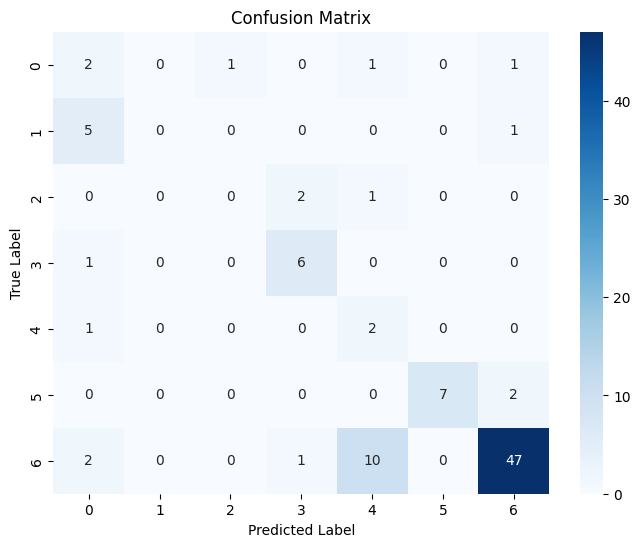

In [7]:
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
dataset_name = 'FER_Aligned'
model_path = f'ModelsReadyForComparison/ResNet50_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResNet50(data_directory, model_path, batch_size=15, ignored_labels=[7])

Number of classes: 8
Test Accuracy: 0.4631578947368421
Precision (Weighted): 0.7102198183205047
Precision (Macro): 0.38319060166886254
Precision (Micro): 0.4631578947368421
Recall (Weighted): 0.4631578947368421
Recall (Macro): 0.5404761904761904
Recall (Micro): 0.4631578947368421
F1 Score (Weighted): 0.4918263767142875
F1 Score (Macro): 0.3912540357508465
F1 Score (Micro): 0.4631578947368421

Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.80      0.32         5
           1       0.33      0.33      0.33         6
           2       0.13      0.67      0.22         3
           3       0.60      0.86      0.71         7
           4       0.11      0.33      0.17         3
           5       0.82      1.00      0.90         9
           6       0.87      0.33      0.48        60
           7       0.00      0.00      0.00         2

    accuracy                           0.46        95
   macro avg       0.38      0.54     

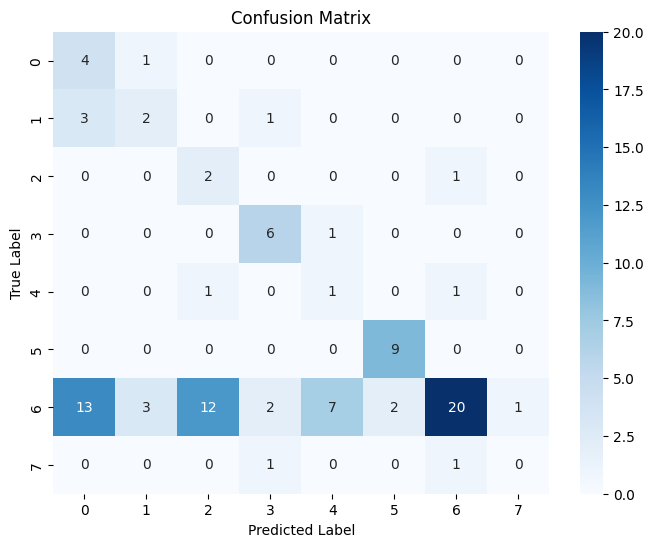

In [8]:
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
dataset_name = 'AffectNet_Aligned'
model_path = f'ModelsReadyForComparison/ResNet50_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResNet50(data_directory, model_path, batch_size=15)

Number of classes: 7
Test Accuracy: 0.7956989247311828
Precision (Weighted): 0.7858585858585859
Precision (Macro): 0.4487734487734487
Precision (Micro): 0.7956989247311828
Recall (Weighted): 0.7956989247311828
Recall (Macro): 0.5547619047619048
Recall (Micro): 0.7956989247311828
F1 Score (Weighted): 0.7816917234648099
F1 Score (Macro): 0.48606298354582106
F1 Score (Micro): 0.7956989247311828

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.44      0.67      0.53         6
           2       0.00      0.00      0.00         3
           3       0.50      1.00      0.67         7
           4       0.33      0.33      0.33         3
           5       0.90      1.00      0.95         9
           6       0.96      0.88      0.92        60

    accuracy                           0.80        93
   macro avg       0.45      0.55      0.49        93
weighted avg       0.79      0.80     

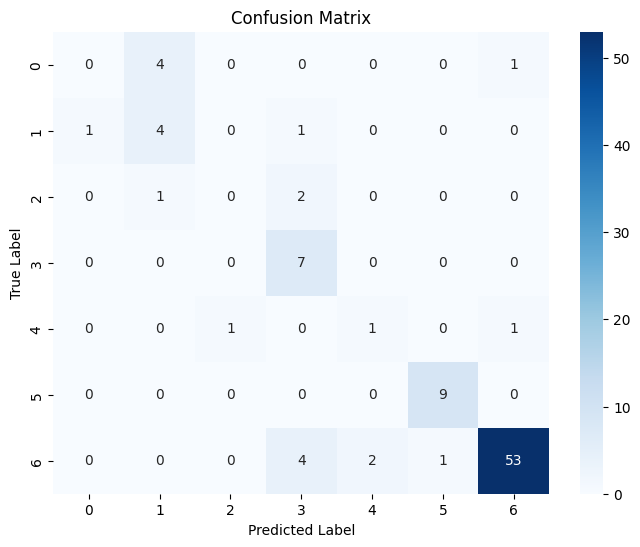

In [51]:
# data_directory = '../../Datasets/RAF-DB_Structured_Aligned'
# data_directory = '../../Datasets/AffectNet_Structured_Aligned'
data_directory = '../../Datasets/CK+_Structured_Aligned'
# data_directory = '../../Datasets/FER_Structured_Aligned'
# data_directory = '../../Datasets/JAFFE_Structured_Aligned'

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
dataset_name = 'RAF-DB_Aligned'
model_path = f'ModelsReadyForComparison/ResNet50_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth'

TestResNet50(data_directory, model_path, batch_size=15, ignored_labels=[7]) 